Current version: 2.1 (2025.05.14)

Previous version: 2.0 (2025.05.09)

```
MIT License

Copyright (c) 2023-2025 Lorenzo Scipioni

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

# **Introduction**

This is a code for processing sine-cosine spectral data developed for bioluminescence phasors on the Phasor Scope.

---


By *Lorenzo Scipioni*

---

Files needed (tiff format):
1.   3-channel images (INT - COS - SIN)
2.   Bright Calibration
3.   Dark Calibration
4.   Registration file





# **Flags**
**FLAG_SAVE_IMAGES:**

Set it to **True** if you want the data to be saved (e.g., overtime exp, BRET efficiency and other experiments that need postprocessing), otherwise set it to **False** (saves time and storage, processed files are large)

**FLAG_REGISTRATION_PRECALCULATE:**

Set it to **True** if you want the registration matrix to be calculated on the first image in the folder and applied to the rest (more stable between files, better for dim samples but register on the brightest). Set it to **False** if you want the registration to be recalculated for each file.

# **Calibration Paths**
Copy-paste here the path to the calibration **FOLDER** (files in .tif format from your Google Drive)

To do so, right-click on the file or folder from the menu on the left and select "Copy path", then paste it between apostrophes (' ') below.

# **Experiment Analysis**
Copy-paste here the path to the experiment **FOLDER** (containing the .tif files arranged in **FOLDERS** of the experiments you want to analyze.)

To do so, right-click on the file or folder from the menu on the left and select "Copy path", then paste it between apostrophes (' ') below.

In [ ]:
# @title **Automatic - Install and import libraries**
try:
    print("Mounting Google Drive...")
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)
    print("Installing libraries...")
    %pip install cellpose
except ImportError:
    pass

print("Import libraries...")
import math
import os
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import skimage
import tifffile
import matplotlib.colors as mcolors

from pathlib import Path
from cellpose import models
from scipy.ndimage import gaussian_filter
from skimage.filters import median
from skimage.morphology import disk

Mounting Google Drive...
Mounted at /content/drive
Installing libraries...
Import libraries...


Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [ ]:
# @title **Automatic - Functions definition**

print("Function definition...")
def get_labeled_ROIs(img_bright, thr, n_regions=3):
    # this function gets the region of the two largest ROIs above a defined threshold, sorted by x-position (left to right)
    labeled_image, num_labels = scipy.ndimage.label(img_bright > thr)
    regions = scipy.ndimage.find_objects(labeled_image)
    region_sizes = [np.sum(labeled_image[region]) for region in regions]
    sorted_regions = sorted(zip(region_sizes, regions), reverse=True)
    largest_regions = sorted_regions[:n_regions]
    region_ROIs_start = [region[1][1].start for region in largest_regions]
    largest_regions = [largest_regions[i] for i in np.argsort(region_ROIs_start)]
    new_labeled_image = np.zeros_like(labeled_image)
    for i, (_, region) in enumerate(largest_regions, start=1):
        new_labeled_image[region] = i
    return new_labeled_image, largest_regions

def Apply_Calibration(img, Calibration):
    CH = [img[Slice] - Calibration["Value Calibration_Dark"] for Slice in Calibration["Slices"]]
    if len(img.shape) == 3:
        CH[1] = CH[1] / Calibration["Bright"][0][:, :, None]
        CH[2] = CH[2] / Calibration["Bright"][1][:, :, None]
    else:
        CH[1] = CH[1] / Calibration["Bright"][0]
        CH[2] = CH[2] / Calibration["Bright"][1]
    return CH

def Process_Img(img, Processing, ComputeMask=True):
    if Processing["Bkg_subtraction"] != 0:
        tmp_img_bkg = img - skimage.filters.gaussian(img, Processing["Bkg_subtraction"])
        tmp_img_bkg[tmp_img_bkg < 0] = 0
    else:
        tmp_img_bkg = img

    img_processed = median(tmp_img_bkg, disk(Processing["Median_filter"]))

    if ComputeMask:
        masks = Processing["Cellpose_model"].eval(img_processed, diameter=Processing["Cellpose_diameter"])[0]
    else:
        masks = []
    return img_processed, masks

def plot_grid(ax, radii=[0, 0.25, 0.5, 0.75, 1], angles=np.arange(0, 360, 45), color="white"):
    for radius in radii:
        circle = plt.Circle((0, 0), radius, fill=False, linestyle="-", color=color)
        ax.add_artist(circle)
    for angle in angles:
        x = [0, np.cos(np.deg2rad(angle))]
        y = [0, np.sin(np.deg2rad(angle))]
        ax.plot(x, y, linestyle="--", color=color)

def preprocess(folder_path, radius=None, sigma=None):
    files_all = os.listdir(folder_path)
    files = []
    img = None
    for file in files_all:
        if "tif" in file.split(".")[-1]:
            files.append(file)
    if not files:
        print(f"Error: No 'tiff' files found in {folder_path}")
        return None  # Explicitly return None to signal an error
    for file in files:
        if file == files[0]:
            img = tifffile.imread(folder_path + "/" + file)[:, :, None]
        else:
            img = np.concatenate((img, tifffile.imread(folder_path + "/" + file)[:, :, None]), axis=2)
    if radius is not None:
        print(f"Removing hot pixels with median filter radius: {radius}")
        disk_element = disk(radius)
        img = np.dstack([median(img[:, :, i], disk_element, mode="reflect") for i in range(img.shape[2])])
    if sigma is not None:
        print(f"Applying gaussian smoothing sigma: {sigma}...")
        img = np.dstack([gaussian_filter(img[:, :, i], sigma=sigma) for i in range(img.shape[2])])
    return img

def norm_slicing(tld, img, dark, region=3, plots=False):

    print("Automatically selecting ROIs...")
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Original")
    binary_mask = img > tld
    axes[1].imshow(binary_mask, cmap="gray")
    axes[1].set_title("Manual Threshold")
    labeled_rois_img, rois_info = get_labeled_ROIs(img, tld, region)
    axes[2].imshow(labeled_rois_img, cmap="viridis")
    axes[2].set_title("Detected ROIs")
    for ax in axes:
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

    print("Channel Ratios - Define common ROIs...")
    roi_slices = [roi[1] for roi in rois_info]
    row_slices = [sl[0] for sl in roi_slices]
    col_slices = [sl[1] for sl in roi_slices]

    dL_R = min(sl.stop - sl.start for sl in row_slices)
    dL_C = min(sl.stop - sl.start for sl in col_slices)
    CH1_slice, CH2_slice, CH3_slice = [
        (slice(row.start, row.start + dL_R), slice(col.start, col.start + dL_C))
        for row, col in zip(row_slices, col_slices)
    ]

    CH1_ROI = img[CH1_slice] - dark
    CH2_ROI = img[CH2_slice] - dark
    CH3_ROI = img[CH3_slice] - dark

    if plots:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
        axes[0].imshow(CH1_ROI)
        axes[0].set_title("CH1")
        axes[1].imshow(CH2_ROI)
        axes[1].set_title("CH2")
        axes[2].imshow(CH3_ROI)
        axes[2].set_title("CH3")
        for ax in axes:
            ax.set_axis_off()
        plt.tight_layout()
        plt.show()

    return CH1_ROI, CH2_ROI, CH3_ROI, CH1_slice, CH2_slice, CH3_slice

def ratio_sc(ch1, ch2, ch3, plots=False):
    print("Channel Ratios - Define and plot...")
    R_cos_int = ch2 / ch1
    R_sin_int = ch3 / ch1
    if plots:
        fig, ax = plt.subplots(ncols=2)
        ax = np.ravel(ax)
        ax[0].imshow(R_cos_int, vmin=0.5, vmax=1.5, cmap="bwr")
        ax[0].set_axis_off()
        ax[1].imshow(R_sin_int, vmin=0.5, vmax=1.5, cmap="bwr")
        ax[1].set_axis_off()
        plt.show()
    return R_cos_int, R_sin_int

def Calculate_Phasors(CH_list, calibration, Processing):
    SinCos_Fcos = np.asarray(calibration["SinCos_Fcos"])
    SinCos_Fsin = np.asarray(calibration["SinCos_Fsin"])
    img_g = 2 * (CH_list[1] / CH_list[0] - SinCos_Fcos[0]) / (SinCos_Fcos[1] - SinCos_Fcos[0]) - 1
    img_s = 2 * (CH_list[2] / CH_list[0] - SinCos_Fsin[0]) / (SinCos_Fsin[1] - SinCos_Fsin[0]) - 1
    img_g = median(img_g,disk(Processing['Median_filter_GS']))
    img_s = median(img_s,disk(Processing['Median_filter_GS']))
    img_ph = np.arctan2(img_s, img_g) % (2 * math.pi)
    img_mod = np.hypot(img_g, img_s)
    return img_g, img_s, img_ph, img_mod

def CCF2D(img1, img2, L_CCF):
    Size = np.shape(img1)
    F1 = np.fft.fft2(img1)
    F2 = np.fft.fft2(img2)
    CCF = F1 * np.conjugate(F2)
    G = np.sum(img1) * np.sum(img2) / Size[0] / Size[1]
    CCF = np.real(np.fft.fftshift(np.fft.ifft2(CCF), axes=(0, 1))) / G - 1
    CCF = CCF[Size[0] // 2 - L_CCF : Size[0] // 2 + L_CCF, Size[1] // 2 - L_CCF : Size[1] // 2 + L_CCF]
    return CCF

def normalize_percentile(data):
    data = np.array(data)
    min_val = np.percentile(data, 1)
    max_val = np.percentile(data, 99)

    if min_val == max_val:
        return np.zeros_like(data)

    normalized_data = (data - min_val) / (max_val - min_val)
    normalized_data[normalized_data < 0] = 0
    normalized_data[normalized_data > 1] = 1
    return normalized_data

def autocorr(CH_list):
    shift_list = []
    for i_img in range(1, 3):
        L = np.min(CH_list[0].shape) // 2
        CCF = CCF2D(CH_list[0], CH_list[i_img], L)
        shift = np.asarray([s[0] - L for s in np.where(CCF == CCF.max())]).astype(int)
        shift_list.append(shift)
    return shift_list

Function definition...


In [ ]:
# @title **User input - Define Sine and Cosine filters parameters...**
SinCos_Fsin = np.asarray([11.2, 92.8]) / 100
SinCos_Fcos = np.asarray([10.9, 94.3]) / 100
SinCos_Lambda = np.asarray([400, 700])

In [ ]:
# @title **User input - Declaring file paths** (copy-paste path to each file, see below)
# %% CALIBRATION PATHS
# Path to the dark calibration file (same parameters as experiments)
Dark_Path = "/content/drive/Shareddrives/Prescher Lab/Phasor Data Analysis/Data for tutorial/Calibration/Dark - 2min"

# Path to the dark calibration file for bright calibration (same parameters as bright)
Dark_Bright_Path = (
    "/content/drive/Shareddrives/Prescher Lab/Phasor Data Analysis/Data for tutorial/Calibration/Dark - 200ms"
)

# Path to the bright calibration file
Bright_Path = (
    "/content/drive/Shareddrives/Prescher Lab/Phasor Data Analysis/Data for tutorial/Calibration/Bright - Lamp"
)

# %% EXPERIMENT FOR REGISTRATION
# Path to the registration experiment (one experiment from the dataset)
Registration_Path = (
    "/content/drive/Shareddrives/Prescher Lab/Phasor Data Analysis/Data for tutorial/Experiments/MB-YenL - 1 - Bio"
)

# %% EXPERIMENT ANALYSIS
# Path to the experiment folder (inside this, each experiment is a folder with .tiff files for each frame)
Experiment_Folder_Path = "/content/drive/Shareddrives/Prescher Lab/Phasor Data Analysis/Data for tutorial/Experiments"

# Whether to save analyzed images as PNG (slower)
FLAG_SAVE_IMAGES = "True"  # @param ["True", "False"]

In [ ]:
# @title **Automatic - Define Calibration paths and load files**
radius = 2
sigma = 3

print("Loading Dark Files... ")
# Load dark path (for experiments) and calcute offset
images_dark = preprocess(Dark_Path, radius=radius)
dark = np.median(images_dark)

print("Loading Bright-Dark Files... ")
# Load bright dark path (for bright) and calculate offset
images_bright_dark = preprocess(Dark_Bright_Path, radius=radius)
bright_dark = np.median(images_bright_dark)

print("Loading Calibration Files... ")
# Load bright IMAGE and remove offset
images_bright = preprocess(Bright_Path, radius=radius, sigma=sigma)
img_bright = np.median(images_bright, 2) - bright_dark

Loading Dark Files... 
Removing hot pixels with median filter radius: 2
Loading Bright-Dark Files... 
Removing hot pixels with median filter radius: 2
Loading Calibration Files... 
Removing hot pixels with median filter radius: 2
Applying gaussian smoothing sigma: 3...


Automatically selecting ROIs...


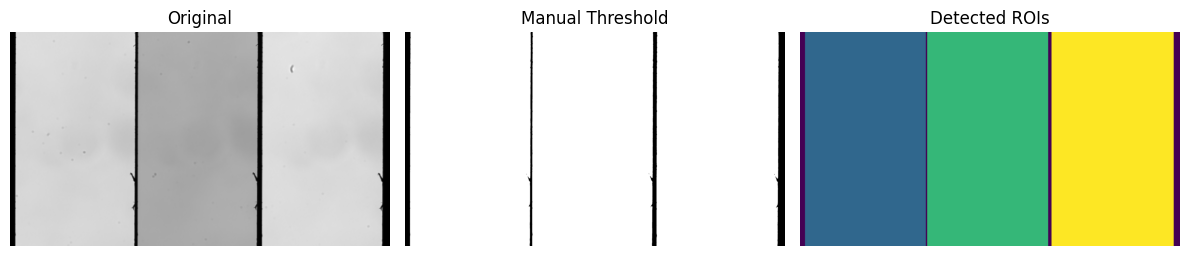

Channel Ratios - Define common ROIs...


In [ ]:
# @title **User input - Define threshold for identifying channels** (the image "Detected ROIs" should show three rectangles corresponding to the three images){run: "auto"}

# Threshold value to allow algorithm to automatically find the three channels (ROI: Region Of Interest)
threshold_value = 3850  # @param {type: "slider", min: 200, max: 10000}
# Extracts ROIs based on threshold, saves ROIs as images and stored pixel coordinates (slice)
CH1_ROI, CH2_ROI, CH3_ROI, CH1_slice, CH2_slice, CH3_slice = norm_slicing(threshold_value, img_bright, dark)
Ch_slice = [CH1_slice, CH2_slice, CH3_slice]

In [ ]:
# @title **Automatic - Initializing selected file for registration**

print("Load registration experiment...")
# Load and process registration image
img_exp = np.median(preprocess(Registration_Path), 2)

print("Correct for channel shifts...")
# Apply slicing (computed above) to registration image
CH_list = [normalize_percentile(img_exp[Ch_slice[n]]) for n in range(3)]

shift = autocorr(CH_list)
# Select the maximum shift found through the autocorrelation function
crop = np.abs(shift).max()
Ch_slice_crop = []

# Apply the crop to all the slices (this step avoids potential negative coordinates)
for n in range(0, 3):
    Ch_slice_crop.append(
        (
            slice(Ch_slice[n][0].start + crop, Ch_slice[n][0].stop - crop),
            slice(Ch_slice[n][1].start + crop, Ch_slice[n][1].stop - crop),
        )
    )

# Apply the shifts calculated above
Ch_slice_new = []
Ch_slice_new.append(Ch_slice_crop[0])
for n in range(1, 3):
    Ch_slice_new.append(
        (
            slice(Ch_slice_crop[n][0].start - shift[n - 1][0], Ch_slice_crop[n][0].stop - shift[n - 1][0]),
            slice(Ch_slice_crop[n][1].start - shift[n - 1][1], Ch_slice_crop[n][1].stop - shift[n - 1][1]),
        )
    )

Load registration experiment...
Correct for channel shifts...


Channel Ratios - Define and plot...


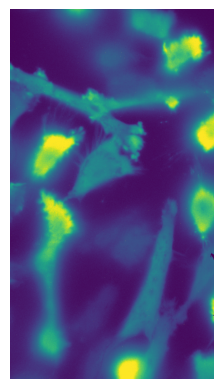

In [ ]:
# @title **User input - Manual crop** (Removes a number of pixels from the sides if a border error is apparent){run: "auto"}

# Number of pixels to remove from each side
Left = 5  # @param {type: "slider", min: 0, max: 200}
Right = 30  # @param {type: "slider", min: 0, max: 200}
Top = 10  # @param {type: "slider", min: 0, max: 500}
Bottom = 10  # @param {type: "slider", min: 0, max: 500}

# Define manual cropping parameters
Crop = [Top, Bottom, Left, Right]
# Return cropped ROIs
Ch_slices = []
for ch_slice in Ch_slice_new:
    Ch_slices.append(
        (
            slice(ch_slice[0].start + Top, ch_slice[0].stop - Bottom),
            slice(ch_slice[1].start + Left, ch_slice[1].stop - Right),
        )
    )

print("Channel Ratios - Define and plot...")
fig, ax = plt.subplots(ncols=1)
min1 = np.percentile(img_exp[Ch_slices[0]], 1)
max1 = np.percentile(img_exp[Ch_slices[0]], 99)
ax.imshow(img_exp[Ch_slices[0]], vmin=min1, vmax=max1)
ax.set_axis_off()
plt.show()

In [ ]:
# @title **Automatic - Create experiment dictionary**

# Calculate intensity ratios
CH1_ROI, CH2_ROI, CH3_ROI = [img_bright[Slice] for Slice in Ch_slices]
R_cos_int, R_sin_int = ratio_sc(CH1_ROI, CH2_ROI, CH3_ROI)

# Compute the arithmetic mean along the specified axis, ignoring NaNs.
R_cos_int[np.isnan(R_cos_int)] = np.nanmean(R_cos_int)
R_sin_int[np.isnan(R_sin_int)] = np.nanmean(R_sin_int)

# Creates folder for storing analysis parameters
name = Experiment_Folder_Path + "Experiments_PhasorScope"
directory = Path(Experiment_Folder_Path) / name
directory.mkdir(exist_ok=True)

# Creates dictionary for storing analysis parameters
calibration = {
    # Paths
    "Path Calibration_Bright": Bright_Path,
    "Path Calibration_Bright_Dark": Dark_Path,
    "Path Calibration_Dark": Dark_Bright_Path,
    "Path Registration": Registration_Path,
    "Path Experiments Folder": Experiment_Folder_Path,
    # Sine and cosine parameters
    "SinCos_Fsin": [SinCos_Fsin[0], SinCos_Fsin[-1]],
    "SinCos_Fcos": [SinCos_Fcos[0], SinCos_Fcos[-1]],
    # Calibration processing parameters
    "Median Filter for hot pixels removal": radius,
    "Gaussian Filter for bright image smoothing": sigma,
    # User inputs
    "Manual_Threshold": threshold_value,
    # Calibration and registration outputs
    "Value Calibration_Dark": dark,
    "Slices": Ch_slices,
    "Bright": [R_cos_int, R_sin_int],
}

Channel Ratios - Define and plot...


In [ ]:
# @title **Automatic - Define GPU-accelerated default Cellpose model**
print("Defining Cellpose model...")
model = models.CellposeModel(gpu=True)

print("Load registration experiment...")
# Load and process registration image
img_exp = preprocess(Registration_Path, radius=calibration["Median Filter for hot pixels removal"])

print("Applying calibration...")
# Load and process registration image
CH1, CH2, CH3 = Apply_Calibration(img_exp, calibration)

Defining Cellpose model...
Load registration experiment...
Removing hot pixels with median filter radius: 2
Applying calibration...


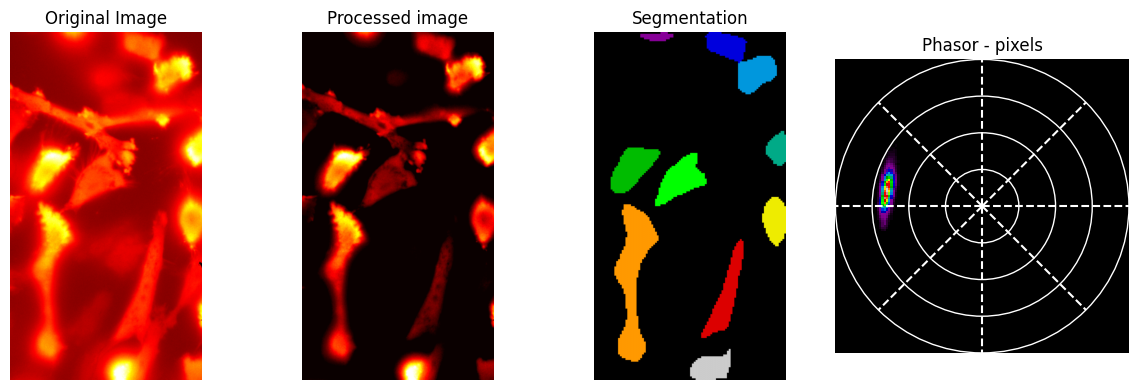

In [ ]:
# @title **User Input - Processing values** (WARNING: Median_filter_GS smooths the phasor images but <u>**Phasors are calculated on UNPROCESSED images**<u>, tune parameters ONLY for optimizing segmentation){run: "auto"}

# How many frames to average for segmentation
Time_binning = 200  # @param {type: "slider", min: 1, max: 200}
# Median filter to image
Median_filter = 3  # @param {type: "slider", min: 1, max: 21, step: 2}
# Background subtration (sigma of gaussian smoothing)
Bkg_subtraction = 400  # @param {type: "slider", min: 0, max: 1001, step: 1}
# Size of cells in pixels
Cellpose_diameter = 356  # @param {type: "slider", min: 5, max: 600}
# Radius of median filter to (g,s) coordinates
Median_filter_GS = 1  # @param {type: "slider", min: 0, max: 21, step: 1}

# Store processing parameters
Processing = {
    "Time_binning": Time_binning,
    "Median_filter": Median_filter,
    "Median_filter_GS": Median_filter_GS,
    "Bkg_subtraction": Bkg_subtraction,
    "Cellpose_diameter": Cellpose_diameter,
    "Cellpose_model": model,
}

# Create a list of slices
CH_list = [np.mean(ch[:, :, :Time_binning], 2) for ch in [CH1, CH2, CH3]]
# Compute image segmentation and generate masks
tmp_img, masks = Process_Img(CH_list[0], Processing)
# Calculate the phasor using the calibration and processing parameters defined above
img_g, img_s, img_ph, img_mod = Calculate_Phasors(CH_list, calibration, Processing)

fig, ax = plt.subplots(ncols=4, figsize=(12, 4))
ax[1].imshow(tmp_img, vmax=np.percentile(tmp_img, 99.9), cmap="hot")
ax[1].set_title("Processed image")
ax[1].set_axis_off()
ax[1].set_aspect(1)
ax[2].imshow(masks, cmap="nipy_spectral")
ax[2].set_title("Segmentation")
ax[2].set_axis_off()
ax[2].set_aspect(1)
# ax[0].imshow(CH_list[0], vmax=np.percentile(tmp_img, 99.9), cmap="hot")
# ax[0].set_title("Original Image")
# ax[0].set_axis_off()
# ax[0].set_aspect(1)
ax[0].imshow(CH_list[0], vmax=np.percentile(CH_list[0], 99.9), cmap="hot")
ax[0].set_title("Original Image")
ax[0].set_axis_off()
ax[0].set_aspect(1)

gs_lim = 1
ax[3].hist2d(
    img_g[masks > 0],
    img_s[masks > 0],
    bins=128,
    range=np.asarray([[-gs_lim, gs_lim], [-gs_lim, gs_lim]]),
    cmap="nipy_spectral",
)
ax[3].set_axis_off()
ax[3].set_title("Phasor - pixels")
ax[3].set_aspect(1)
plot_grid(ax[3], radii=[0, 0.25, 0.5, 0.75, 1], angles=np.arange(0, 360, 45), color="white")
plt.tight_layout()

In [ ]:
# @title **Automatic - Save calibration and processing parameters...**

# Save the calibration parameters
np.save(Experiment_Folder_Path + "/Calibration.npy", calibration)
with open(os.path.join(Experiment_Folder_Path, "Calibration"), "w") as f:
    f.write(str(calibration))
# Save the processing parameters
np.save(Experiment_Folder_Path + "/Processing.npy", Processing)

Found: 1 files
Starting experiment(s) analysis...
Experiment #1/1
Experiment name: MB-YenL - 1 - Bio
Loading...
Removing hot pixels with median filter radius: 2
Applying calibration...
Applying time average...
Applying image processing...
Calculating Phasors...
Plotting phasors...


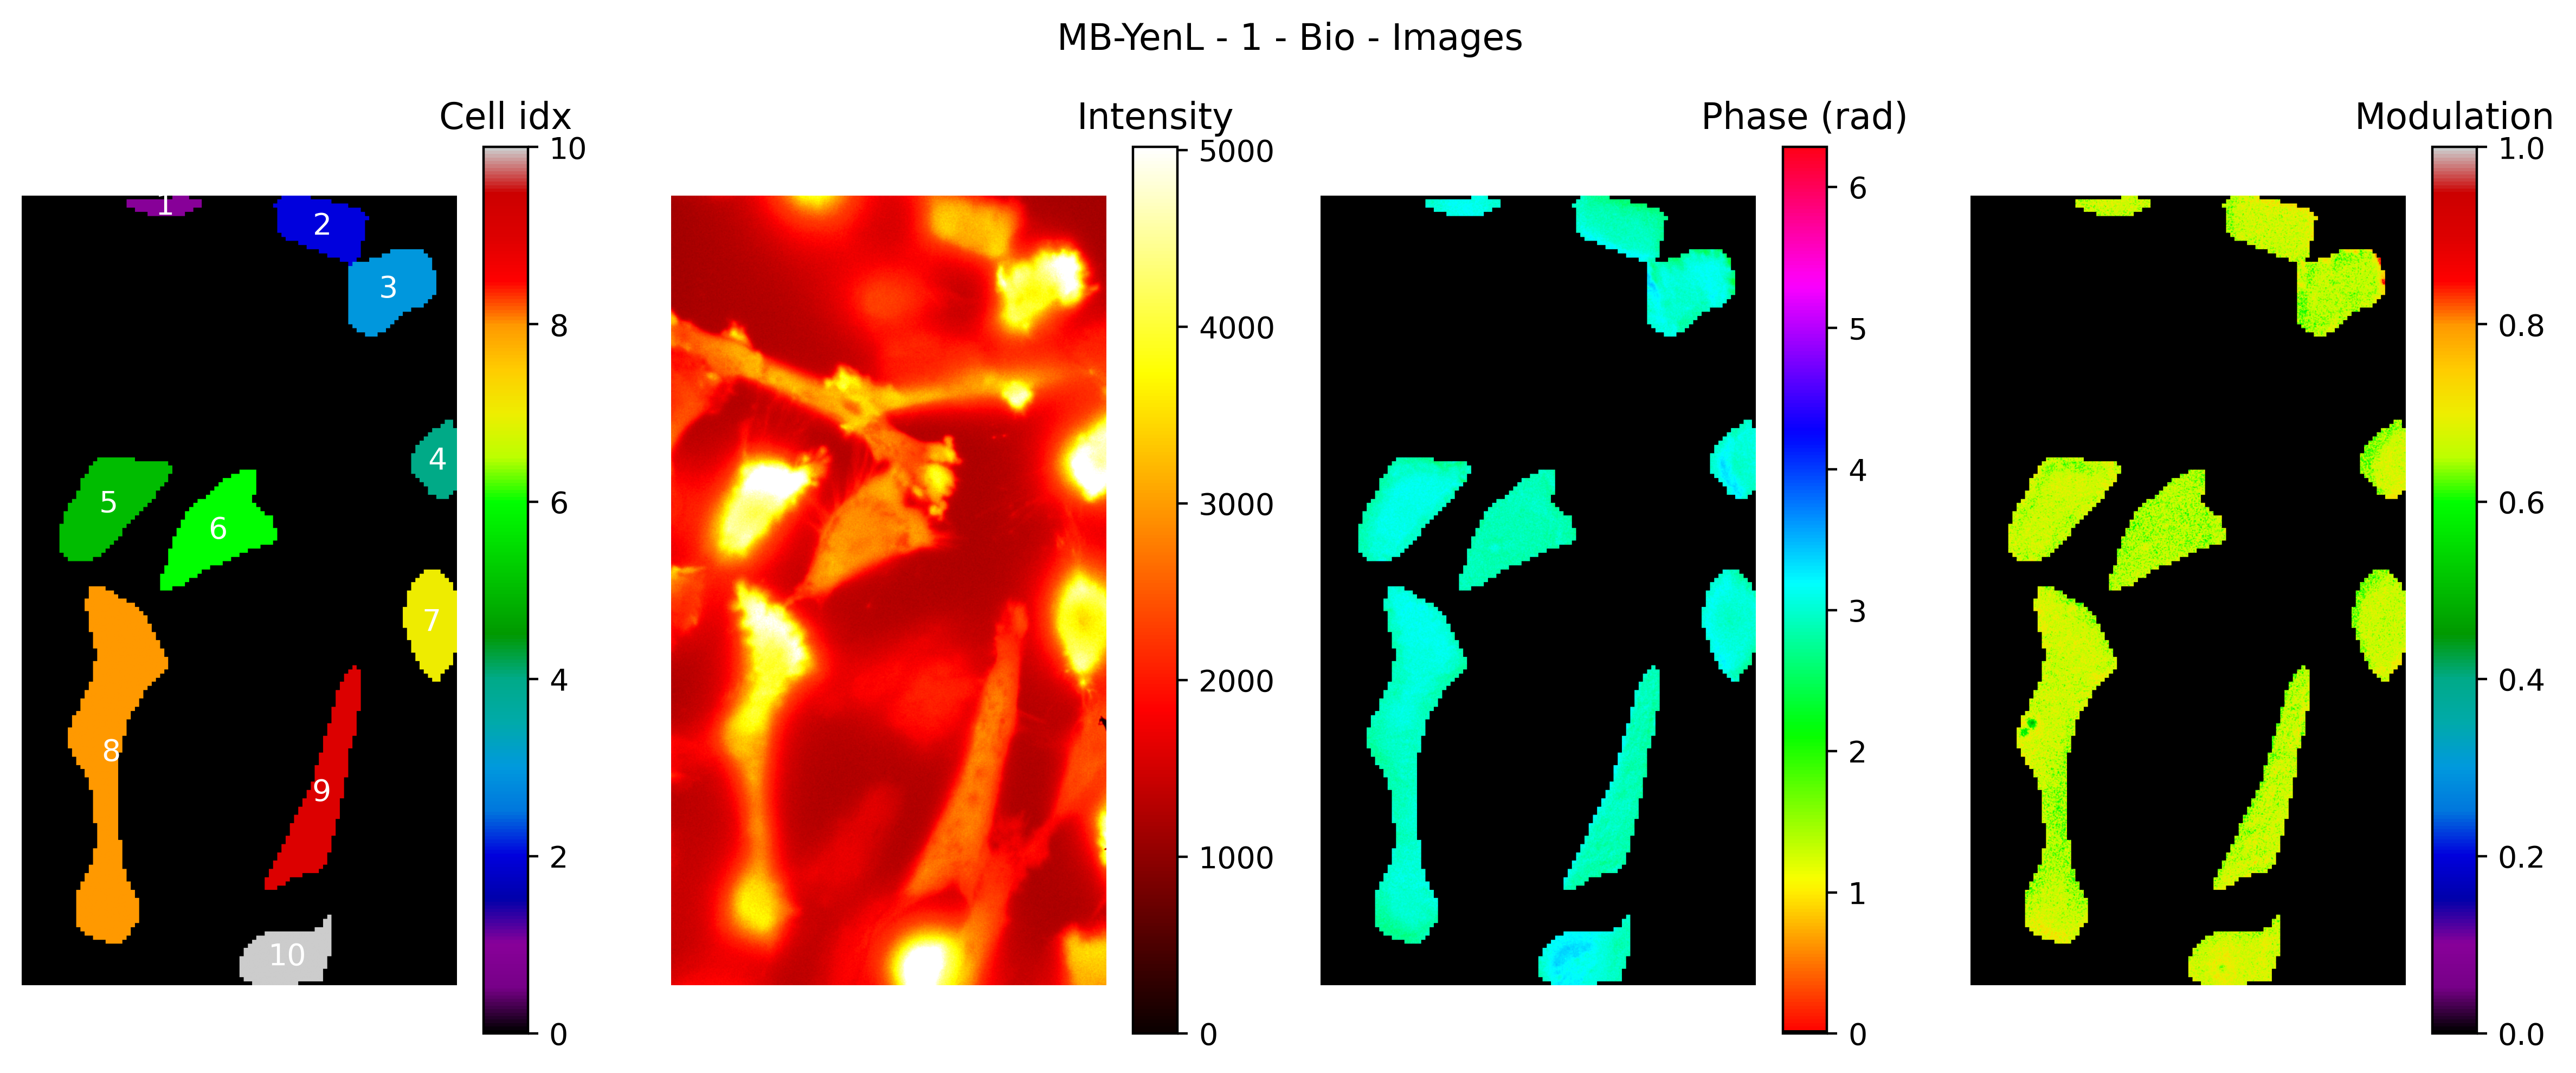

<ipython-input-13-e9db66dfbe02>:130: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat((df, df_tmp))
<ipython-input-13-e9db66dfbe02>:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, df_tmp))


Saving...


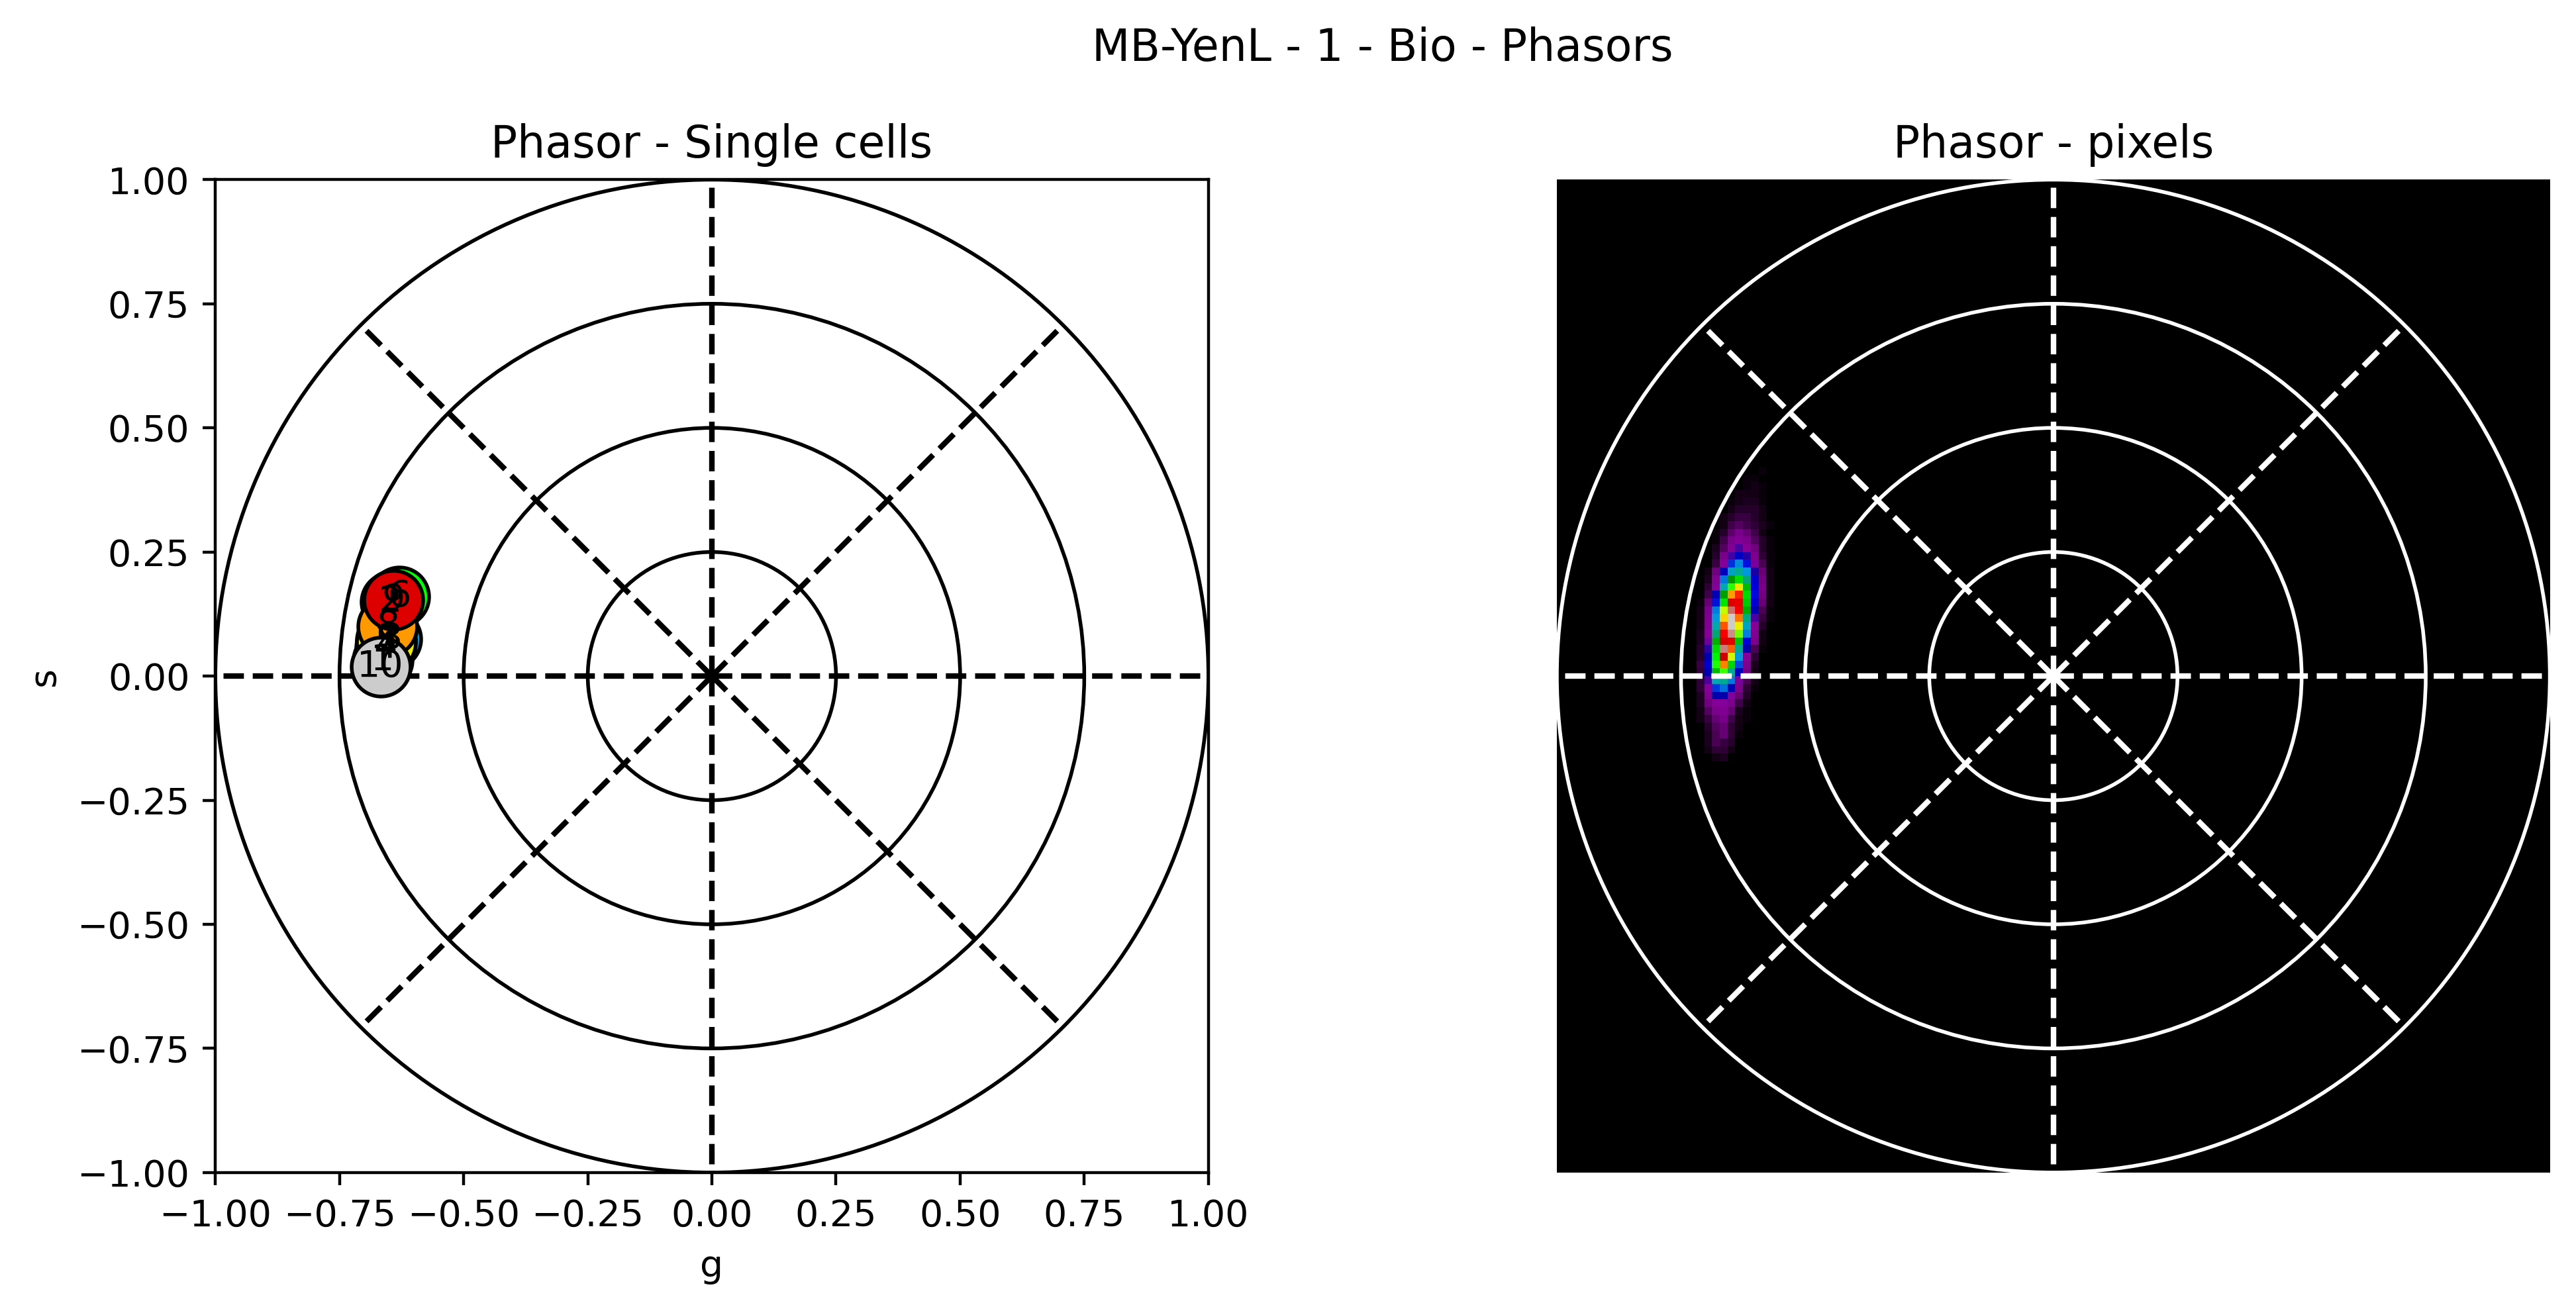

<ipython-input-13-e9db66dfbe02>:149: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_all = pd.concat((df_all, df))
<ipython-input-13-e9db66dfbe02>:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat((df_all, df))


In [ ]:
# @title **Automatic - Process all experiment files**
figsize = (12,5)

# Load experiments from folder
Experiments_Path = []
for file in os.listdir(Experiment_Folder_Path):
    if (os.path.isdir(Experiment_Folder_Path + "/" + file)) & (("Experiments_PhasorScope" not in file)):
        Experiments_Path.append(Experiment_Folder_Path + "/" + file)

print("Found: " + str(len(Experiments_Path)) + " files")

# Define dataframe
print("Starting experiment(s) analysis...")
Columns = ("g", "s", "intensity (cam1 sum INT)", "intensity (cam2 sum INT)", "x", "y", "color", "fname")
df_all = pd.DataFrame(columns=Columns, index=[])
dy_text = 0

# Custom colormap for phase images
hsv = plt.colormaps.get_cmap('hsv')
colors = [(0, 0, 0)]  # RGB for black
n_steps = 256  # Number of color steps in the final colormap
for i in range(1, n_steps):
    colors.append(hsv(i / (n_steps - 1)))
cmap_custom = mcolors.LinearSegmentedColormap.from_list("hsv_black_start", colors)

# Load processing and calibration parameters
Processing = np.load(Experiment_Folder_Path + "/Processing.npy", allow_pickle=True).item()
Calibration = np.load(Experiment_Folder_Path + "/Calibration.npy", allow_pickle=True).item()

# Compute experiment analysis.
# The loop calibrates and processes the experiment data one by one.
# Final plots include: Experiment title
# - Cell masks
# - Image intensity
# - Phase
# - Modulation
# - Phasor - Single cells
# - Phasor - Single pixel

for i_exp, exp_path in enumerate(Experiments_Path[:]):
    try:
        print("Experiment #" + str(i_exp + 1) + "/" + str(len(Experiments_Path)))
        fname = exp_path.split("/")[-1]
        print("Experiment name: " + fname)

        print("Loading...")
        img_exp = preprocess(exp_path, radius=Calibration["Median Filter for hot pixels removal"])
        print("Applying calibration...")
        CH1, CH2, CH3 = Apply_Calibration(img_exp, Calibration)
        print("Applying time average...")
        CH1, CH2, CH3 = [np.median(ch[:, :, : Processing["Time_binning"]], 2) for ch in [CH1, CH2, CH3]]
        print("Applying image processing...")
        tmp_img, masks = Process_Img(CH1, Processing)
        print("Calculating Phasors...")
        img_g, img_s, img_ph, img_mod = Calculate_Phasors([CH1, CH2, CH3], Calibration, Processing)

        print("Plotting phasors...")
        cmap = plt.get_cmap("nipy_spectral")
        CMap = cmap(np.linspace(0, 1, np.max(masks) + 1))
        df = pd.DataFrame(columns=Columns, index=[])

        # Images - Phasors as median of g,s
        fig, ax = plt.subplots(ncols=4, dpi=400, figsize=figsize)
        img1 = ax[0].imshow(masks, cmap="nipy_spectral")
        cbar = plt.colorbar(img1)
        cbar.ax.set_title("Cell idx")
        ax[0].set_axis_off()
        for i_cells in range(0, np.max(masks)):
            cell_idx = i_cells + 1
            logic = masks == (cell_idx)
            idx = np.where(logic)
            g_cell = np.median(img_g[logic])
            s_cell = np.median(img_s[logic])
            x_cell = np.mean(idx[0])
            y_cell = np.mean(idx[1])
            ax[0].arrow(y_cell + dy_text, x_cell - dy_text, -dy_text, dy_text, color="gray", linewidth=0.3)
            ax[0].text(
                y_cell + dy_text,
                x_cell - dy_text,
                str(cell_idx),
                color="white",
                horizontalalignment="center",
                verticalalignment="center",
            )
        img2 = ax[1].imshow(CH1, cmap="hot", vmin=0, vmax=np.percentile(CH1, 99))
        cbar = plt.colorbar(img2)
        cbar.ax.set_title("Intensity")
        ax[1].set_axis_off()
        img3 = ax[2].imshow(img_ph * (masks > 0), cmap=cmap_custom, vmin=0, vmax=math.pi * 2)
        cbar = plt.colorbar(img3)
        cbar.ax.set_title("Phase (rad)")
        ax[2].set_axis_off()
        img4 = ax[3].imshow(img_mod * (masks > 0), cmap='nipy_spectral', vmin=0, vmax=1)
        cbar = plt.colorbar(img4)
        cbar.ax.set_title("Modulation")
        ax[3].set_axis_off()
        plt.suptitle(fname + " - Images")
        plt.tight_layout()
        plt.show()

        fig, ax = plt.subplots(ncols=2, dpi=400, figsize=figsize)
        gs_lim = 1
        ax[1].hist2d(
            img_g[masks > 0],
            img_s[masks > 0],
            bins=128,
            range=np.asarray([[-gs_lim, gs_lim], [-gs_lim, gs_lim]]),
            cmap="nipy_spectral",
        )
        ax[1].set_axis_off()
        ax[1].set_title("Phasor - pixels")
        ax[1].set_aspect(1)
        plot_grid(ax[1], radii=[0, 0.25, 0.5, 0.75, 1], angles=np.arange(0, 360, 45), color="white")
        plot_grid(ax[0], radii=[0, 0.25, 0.5, 0.75, 1], angles=np.arange(0, 360, 45), color="black")
        for i_cells in range(0, np.max(masks)):
            cell_idx = i_cells + 1
            logic = masks == (cell_idx)
            idx = np.where(logic)
            CH_list1 = [np.sum(CH_list[n][logic]) for n in range(len(CH_list))]
            g_sum_int_cell = 2 * (CH_list1[1] / CH_list1[0] - SinCos_Fcos[0]) / (SinCos_Fcos[1] - SinCos_Fcos[0]) - 1
            s_sum_int_cell = 2 * (CH_list1[2] / CH_list1[0] - SinCos_Fsin[0]) / (SinCos_Fsin[1] - SinCos_Fsin[0]) - 1
            g_cell = np.median(img_g[logic])
            s_cell = np.median(img_s[logic])
            x_cell = np.mean(idx[0])
            y_cell = np.mean(idx[1])
            df_tmp = pd.DataFrame(
                {"g": g_cell, "s": s_cell, "x": x_cell, "y": y_cell, "color": [CMap[cell_idx]], "fname": fname},
                index=[cell_idx],
            )
            df = pd.concat((df, df_tmp))
            ax[0].plot(g_cell, s_cell, "o", markerfacecolor=CMap[cell_idx], markeredgecolor="k", markersize=16)
            ax[0].text(
                g_cell, s_cell, str(cell_idx), color="black", horizontalalignment="center", verticalalignment="center"
            )
        ax[0].set_xlim([-1, 1])
        ax[0].set_ylim([-1, 1])
        ax[0].set_aspect(1)
        ax[0].set_xlabel("g")
        ax[0].set_ylabel("s")
        ax[0].set_title("Phasor - Single cells")
        plt.suptitle(fname + " - Phasors")
        plt.tight_layout()
        print("Saving...")
        plt.savefig(exp_path + "_Phasors.png")
        plt.tight_layout()
        plt.show()

        df.to_excel(exp_path + ".xlsx")
        df_all = pd.concat((df_all, df))
        if FLAG_SAVE_IMAGES == "True":
            Experiment_Images = {
                "CH_list": CH_list,
                "masks": masks,
                "img_g": img_g,
                "img_s": img_s,
                "img_ph": img_ph,
                "img_mod": img_mod,
                "df": df,
                "Calibration": Calibration,
                "Processing": Processing,
            }
            np.savez_compressed(exp_path + "_Images.npz", Experiment_Images)
    except Exception:
        print("SKIPPED: Experiment #" + str(i_exp + 1) + "/" + str(len(Experiments_Path)))

output_dir = os.path.dirname(exp_path)
output_path = os.path.join(output_dir, "All experiments.xlsx")
df_all.to_excel(output_path)